venv:
- conda create -n pinn python=3
- conda activate pinn
- conda install jupyter numpy matplotlib
- conda install pytorch torchvision torchaudio -c pytorch

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
# Use cuda if available (use model.to(device) to run on device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
print(torch.version.cuda)         # Shows CUDA version PyTorch was built with
print(torch.cuda.is_available())  # Should be True if GPU is usable

12.4
False


In [5]:
class Model(nn.Module):
    # defines a fully connected neural network, with a tanh activation function
    def __init__(self, inputs, outputs, hidden, n_layers):
        super().__init__()
        act_f = nn.Tanh

        # First layer, "*" unpacks the list into arguments of nn.Sequential
        self.fcs = nn.Sequential(*[
                        nn.Linear(inputs, hidden),
                        act_f()])
        
        # Hidden layers with activation function
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(hidden, hidden),
                            act_f()]) for _ in range(n_layers-1)])
        
        # Final layer that maps from last hidden layer to output size
        self.fce = nn.Linear(hidden, outputs)
    
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

Done step 0
Done step 50000
Done step 100000
Done step 150000


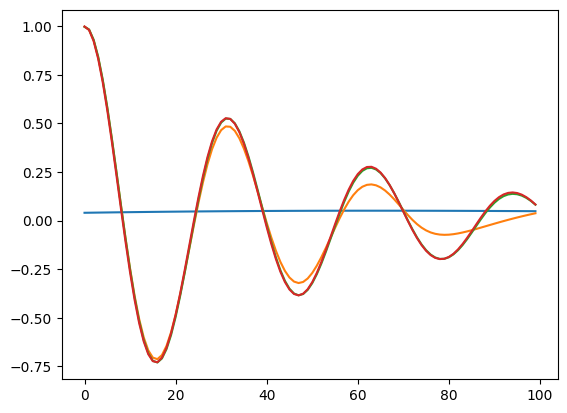

In [ ]:
# 1D spring simulation:
d, w0 = 2, 20 # Conditions for an under-dampened spring
mu, k = 2*d, w0**2

torch.manual_seed(42)
#model with 1 input and output layers (time and amplitude) and 4 hidden layers of 42 neurons
spring_model = Model(1, 1, 42, 4).to(device)
optimizer = torch.optim.Adam(spring_model.parameters(),lr=1e-4)

x_physics = torch.linspace(0,1,100).view(-1,1).requires_grad_(True) # generate time inputs
x_physics = x_physics.to(device)

last_res = np.array(0)

for i in range(150001):
    optimizer.zero_grad()
    
    # compute the "physics loss"
    yhp = spring_model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
    loss_phys = (1e-4)*torch.mean(physics**2)

    #If time is 0, we want an amplitude of 1 (boundary condition)
    loss_BC = abs(1-yhp[0])
    
    # backpropagate joint loss
    loss = loss_phys + loss_BC# add two loss terms together
    loss.backward()
    optimizer.step()

    if i%50000 == 0:
        print(f"Done step {i}")
        to_display = yhp.cpu()
        to_display = to_display.detach().numpy()
        last_res = to_display
        plt.plot(to_display)



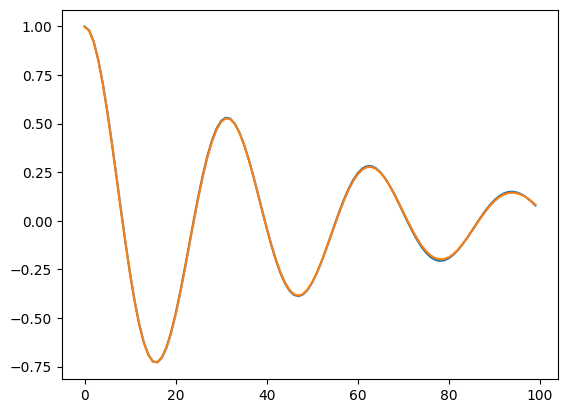

In [47]:
# Real spring, just to compare
def oscillator(d, w0, x):
    assert d < w0 # check if really underdampened
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

x = torch.linspace(0,1,100).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)

plt.plot(y)
plt.plot(last_res)

In [ ]:
def generate_points():
    pass

Reynolds number: 200.0


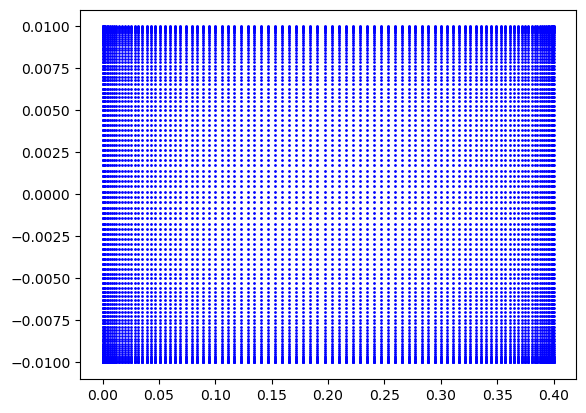

In [ ]:
# Simulation parameters
h = 0.01
L = 0.2
u_avg = 0.01
rho = 1000
mu = 0.001
Re = (rho * u_avg * 2*h) / mu
print(f"Reynolds number: {Re}")

h_factor = 2 # y dim simulation factor (y_max, y_min = +-h * h_factor)
L_factor = 2 # x dim simulation factor (x_max, x_min = L * L_factor, 0)

torch.manual_seed(12)
#model with 2 input (x,y position), 3 output layers (x, y velocity & pressure) and 8 hidden layers of 50 neurons
poiseuille_model = Model(2, 3, 100, 5).to(device)
optimizer = torch.optim.Adam(poiseuille_model.parameters(),lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

x_min, x_max = 0, L*L_factor  # Horizontal span
y_min, y_max = -h*h_factor, h*h_factor  # Vertical span

# Getting x values, with higer density to the left
n_x = 100
skew_x = np.linspace(0, 1, n_x)  # uniform base
x_vals = x_min + (x_max - x_min) * (0.5 - 0.5 * np.cos(np.pi * skew_x)) # skew to the left

# Getting y values, with higher density on the top/bottom
n_y = 100
skew_y = np.linspace(0, 1, n_y)
y_vals = y_min + (y_max - y_min) * (0.5 - 0.5 * np.cos(np.pi * skew_y))

X, Y = np.meshgrid(x_vals, y_vals)

tensor_np = np.column_stack((X.ravel(), Y.ravel()))

tensor = torch.from_numpy(tensor_np).float().to(device).requires_grad_(True)

plt.scatter(tensor_np[:, 0], tensor_np[:, 1], s=1, color='blue')

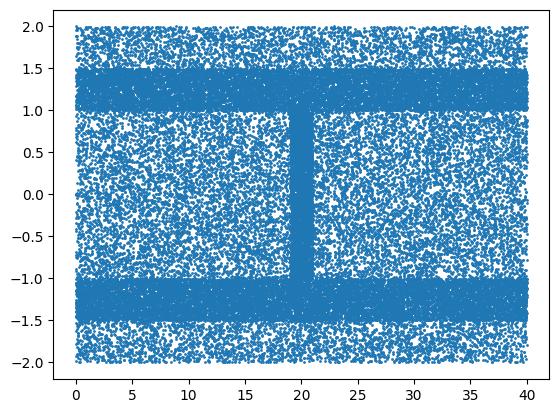

In [11]:
import numpy as np

def generate_points(N):
    # Define zones as (x_min, x_max, y_min, y_max, weight)
    zones = [
        (0, 40, -2, 2, 1),           # Base zone
        (0, 40, 1, 1.5, 3),          # Upper horizontal band
        (0, 40, -1.5, -1, 3),        # Lower horizontal band
        (19, 21, -1, 1, 5)           # Center square
    ]
    
    # Compute area and weighted area of each zone
    weighted_areas = []
    total_weighted_area = 0
    for x_min, x_max, y_min, y_max, weight in zones:
        area = (x_max - x_min) * (y_max - y_min)
        w_area = area * weight
        weighted_areas.append(w_area)
        total_weighted_area += w_area

    # Determine number of points per zone
    points_per_zone = [int((w_area / total_weighted_area) * N) for w_area in weighted_areas]

    # Sample points in each zone
    all_points = []
    for i, (x_min, x_max, y_min, y_max, _) in enumerate(zones):
        count = points_per_zone[i]
        xs = np.random.uniform(x_min, x_max, count)
        ys = np.random.uniform(y_min, y_max, count)
        all_points.append(np.column_stack((xs, ys)))

    # Combine all points into a single array
    points = np.vstack(all_points)

    return points
ah = generate_points(50000)
plt.scatter(ah[:, 0], ah[:, 1], s = 1)

In [36]:
def compute_PDE(xy, y_in):
    u = y_in[:, 0:1]
    v = y_in[:, 1:2]
    p = y_in[:, 2:3]

    # Gradient helper
    grads = lambda out, inp: torch.autograd.grad(out, inp, grad_outputs=torch.ones_like(out), create_graph=True)[0]

    # First-order derivatives
    grads_u = grads(u, xy)
    grads_v = grads(v, xy)
    grads_p = grads(p, xy)

    dudx, dudy = grads_u[:, 0], grads_u[:, 1]
    dvdx, dvdy = grads_v[:, 0], grads_v[:, 1]
    dpdx, dpdy = grads_p[:, 0], grads_p[:, 1]

    # Second-order derivatives
    d2udx2 = grads(dudx, xy)[:, 0]
    d2udy2 = grads(dudy, xy)[:, 1]
    d2vdx2 = grads(dvdx, xy)[:, 0]
    d2vdy2 = grads(dvdy, xy)[:, 1]

    return dudx, dudy, dpdx, dpdy, d2udx2, d2udy2, dvdx, dvdy, d2vdx2, d2vdy2

In [ ]:
from tqdm import trange, tqdm

x_vals_tensor = tensor[:, 0]
y_vals_tensor = tensor[:, 1]

no_slip_mask = (torch.abs(y_vals_tensor - h) < 1e-6) | (torch.abs(y_vals_tensor + h) < 1e-6)
inlet_mask = (torch.abs(x_vals_tensor - x_min) < 1e-6) & (~no_slip_mask)
outlet_mask = (torch.isclose(tensor[:, 0], torch.tensor(x_max).to(tensor), atol=1e-6)) & (~no_slip_mask)
interior_mask = ~(no_slip_mask | inlet_mask | outlet_mask)

for i in trange(10000):
    optimizer.zero_grad()
    
    # Boundray Conditions part
    yhp = poiseuille_model(tensor)

    p_outlet = yhp[outlet_mask, 2]

    outlet_loss = torch.mean(p_outlet**2) * 25
    no_slip_loss = torch.mean(yhp[no_slip_mask, 0])**2 + torch.mean(yhp[no_slip_mask, 1]**2) * 20
    inlet_loss = torch.mean((yhp[inlet_mask, 0] - u_avg)**2) + torch.mean((yhp[inlet_mask, 1])**2) * 20

    #Physics loss part
    x_interior = tensor[interior_mask]
    y_interior = poiseuille_model(x_interior)

    dudx, dudy, dpdx, dpdy, d2udx2, d2udy2, dvdx, dvdy, d2vdx2, d2vdy2 = compute_PDE(x_interior, y_interior)

    navier_x = rho*(y_interior[:, 0] * dudx + y_interior[:, 1] * dudy) + dpdx - mu * (d2udx2 + d2udy2)
    navier_y = rho*(y_interior[:, 0] * dvdx + y_interior[:, 1] * dvdy) + dpdy - mu * (d2vdx2 + d2vdy2)
    continuity = dudx + dvdy

    loss_phys = (torch.mean(navier_x**2) + torch.mean(navier_y**2) + torch.mean(continuity**2))

    loss = loss_phys + 10 * (no_slip_loss + inlet_loss + outlet_loss)

    if i%2000 == 0 or i == 9999:
        tqdm.write(f"Step {i+1}, Loss: {loss.item():.6f}\n Physics: {loss_phys.item():.6f}   No slip: {no_slip_loss.item():.6f}   Inlet: {inlet_loss.item():.6f}   Outlet: {outlet_loss.item():.6f}")

    loss.backward()
    optimizer.step()
    scheduler.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

Step 1, Loss: 4.601354
 Physics: 0.003647   No slip: 0.082751   Inlet: 0.083309   Outlet: 0.293711


 20%|██        | 2001/10000 [04:02<18:04,  7.37it/s]

Step 2001, Loss: 0.000498
 Physics: 0.000001   No slip: 0.000025   Inlet: 0.000025   Outlet: 0.000000


 40%|████      | 4001/10000 [08:04<12:11,  8.20it/s]

Step 4001, Loss: 0.000470
 Physics: 0.000003   No slip: 0.000022   Inlet: 0.000024   Outlet: 0.000000


 60%|██████    | 6001/10000 [11:56<07:38,  8.72it/s]

Step 6001, Loss: 0.000413
 Physics: 0.000008   No slip: 0.000021   Inlet: 0.000019   Outlet: 0.000000


 80%|████████  | 8001/10000 [15:46<03:58,  8.38it/s]

Step 8001, Loss: 0.000400
 Physics: 0.000024   No slip: 0.000021   Inlet: 0.000016   Outlet: 0.000000


100%|██████████| 10000/10000 [19:39<00:00,  8.48it/s]

Step 10000, Loss: 0.000335
 Physics: 0.000012   No slip: 0.000018   Inlet: 0.000014   Outlet: 0.000000


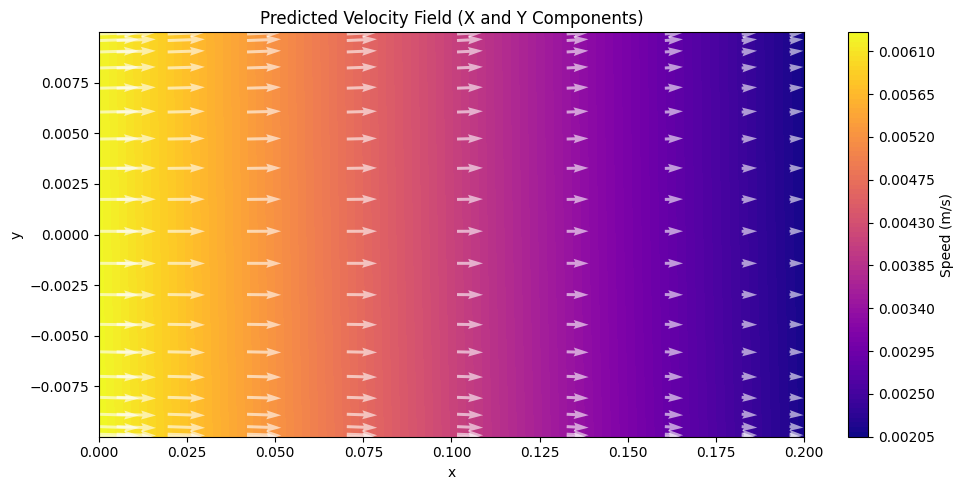

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Detach and convert
u_pred = yhp[:, 0].detach().cpu().numpy()
v_pred = yhp[:, 1].detach().cpu().numpy()
x = tensor[:, 0].detach().cpu().numpy()
y = tensor[:, 1].detach().cpu().numpy()

# Create dataframe
df = pd.DataFrame({'x': x, 'y': y, 'u': u_pred, 'v': v_pred})
df['speed'] = (df['u']**2 + df['v']**2)**0.5

# Pivot for grid-based plotting
pivot_x = df.pivot_table(index='y', columns='x', values='u')
pivot_y = df.pivot_table(index='y', columns='x', values='v')
pivot_speed = df.pivot_table(index='y', columns='x', values='speed')

# Get meshgrid
X, Y = np.meshgrid(pivot_x.columns.values, pivot_x.index.values)

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
c = ax.contourf(X, Y, pivot_speed.va lues, levels=100, cmap='plasma')
cb = fig.colorbar(c, ax=ax, label='Speed (m/s)')

# Optional quiver (velocity vectors, skip some for clarity)
skip = (slice(None, None, 5), slice(None, None, 10))
ax.quiver(X[skip], Y[skip], pivot_x.values[skip], pivot_y.values[skip], color='white', alpha=0.6)

# Styling
ax.set_title('Predicted Velocity Field (X and Y Components)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('auto')
plt.tight_layout()
plt.show()